# Evaluate if the pangenome pipeline produces similar but more complete count profiles as a "gold standard" pipeline when the sample is a strain for which we do not have a reference genome

This notebook examines whether the pangenome pipeline produces counts that correlate with a "gold standard" pipeline. 

The **pangenome pipeline** determines which species the majority of reads come from, generates a reference sequence by downloading all reference genomes for that species, extracts coding and RNA sequences for all genomes, clusters sequences at 95% identity, and mapping (quant) against these sequences using salmon. Intergenic sequences are given to salmon as decoy sequences so that any read that maps better to intergenic sequences (e.g. as may be transcribed in polycistronic transcripts) will not be counted, but will be labelled as mapping to intergenic. 

The **gold standard pipeline** uses STAR to map reads against the best-matching reference genome when the RNA-seq sample is compared against all genomes in the GTDB genome database. 

In this notebook, we present results for three RNA seq samples from the strain *Bacillus_altitudinis*. Many species of *B. altitudinis* were matches between each RNA seq sample and the genomes in the GTDB database, giving strong support that the strain present in each sample is closely related to some reference genomes but is not represented in the reference database. As such, this notebook tests whether pangenome construction captures additional information over what is captured by the best strain match alone.

In [2]:
# change working dir to one level above notebooks dir
setwd("..")

In [3]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(ggplot2)
library(modelr)
library(broom)
source("scripts/utils.R")

In [4]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200) 

### make annotation map between pangenome and reference seq

In [6]:
ba_annot_map <- read_cdhit_clstr("outputs/gtdb_genomes_annotated_comb/s__Bacillus_altitudinis_clustered_annotated_seqs.fa.clstr")

## Single end data

### import and format counts

In [7]:
gs_se_ref_counts <- Sys.glob("outputs/gs_rnaseq_featurecounts/GCF_000299555.2*counts.txt") %>%
  set_names() %>%
  map_dfr(read_delim, delim = " ", skip = 1, show_col_types = FALSE,
          col_names =  c("sequence_name", "chr", "start", "end", "strand", "length", 
                         "gs_se_ref_counts"), .id = "sample") %>%
  mutate(sample = gsub("outputs/gs_rnaseq_featurecounts/GCF_000299555.2-", "", sample)) %>%
  mutate(sample = gsub("_counts.txt", "", sample)) %>%
  select(sequence_name, gs_se_ref_counts, sample)  

salmon <- Sys.glob("outputs/rnaseq_salmon/s__Bacillus_altitudinis/*_quant/quant.sf") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = FALSE, .id = "sample") %>%
  mutate(sample = gsub("outputs/rnaseq_salmon/s__Bacillus_altitudinis/", "", sample)) %>%
  mutate(sample = gsub("_quant/quant.sf", "", sample)) %>%
  select(Name, salmon_counts = NumReads, sample) %>%
  left_join(ba_annot_map, by = c("Name" = "representative")) %>%
  filter(sequence_name %in% gs_se_ref_counts$sequence_name) %>%
  select(sequence_name, salmon_counts, sample)


counts <- full_join(gs_se_ref_counts, salmon, by = c("sequence_name", "sample")) %>%
  mutate(log10_salmon_counts = log10(salmon_counts),
         log10_salmon_counts = ifelse(!is.finite(log10_salmon_counts), 0, log10_salmon_counts),
         log10_gs_se_ref_counts = log10(gs_se_ref_counts), 
         log10_gs_se_ref_counts = ifelse(!is.finite(log10_gs_se_ref_counts), 0, log10_gs_se_ref_counts))

### plot

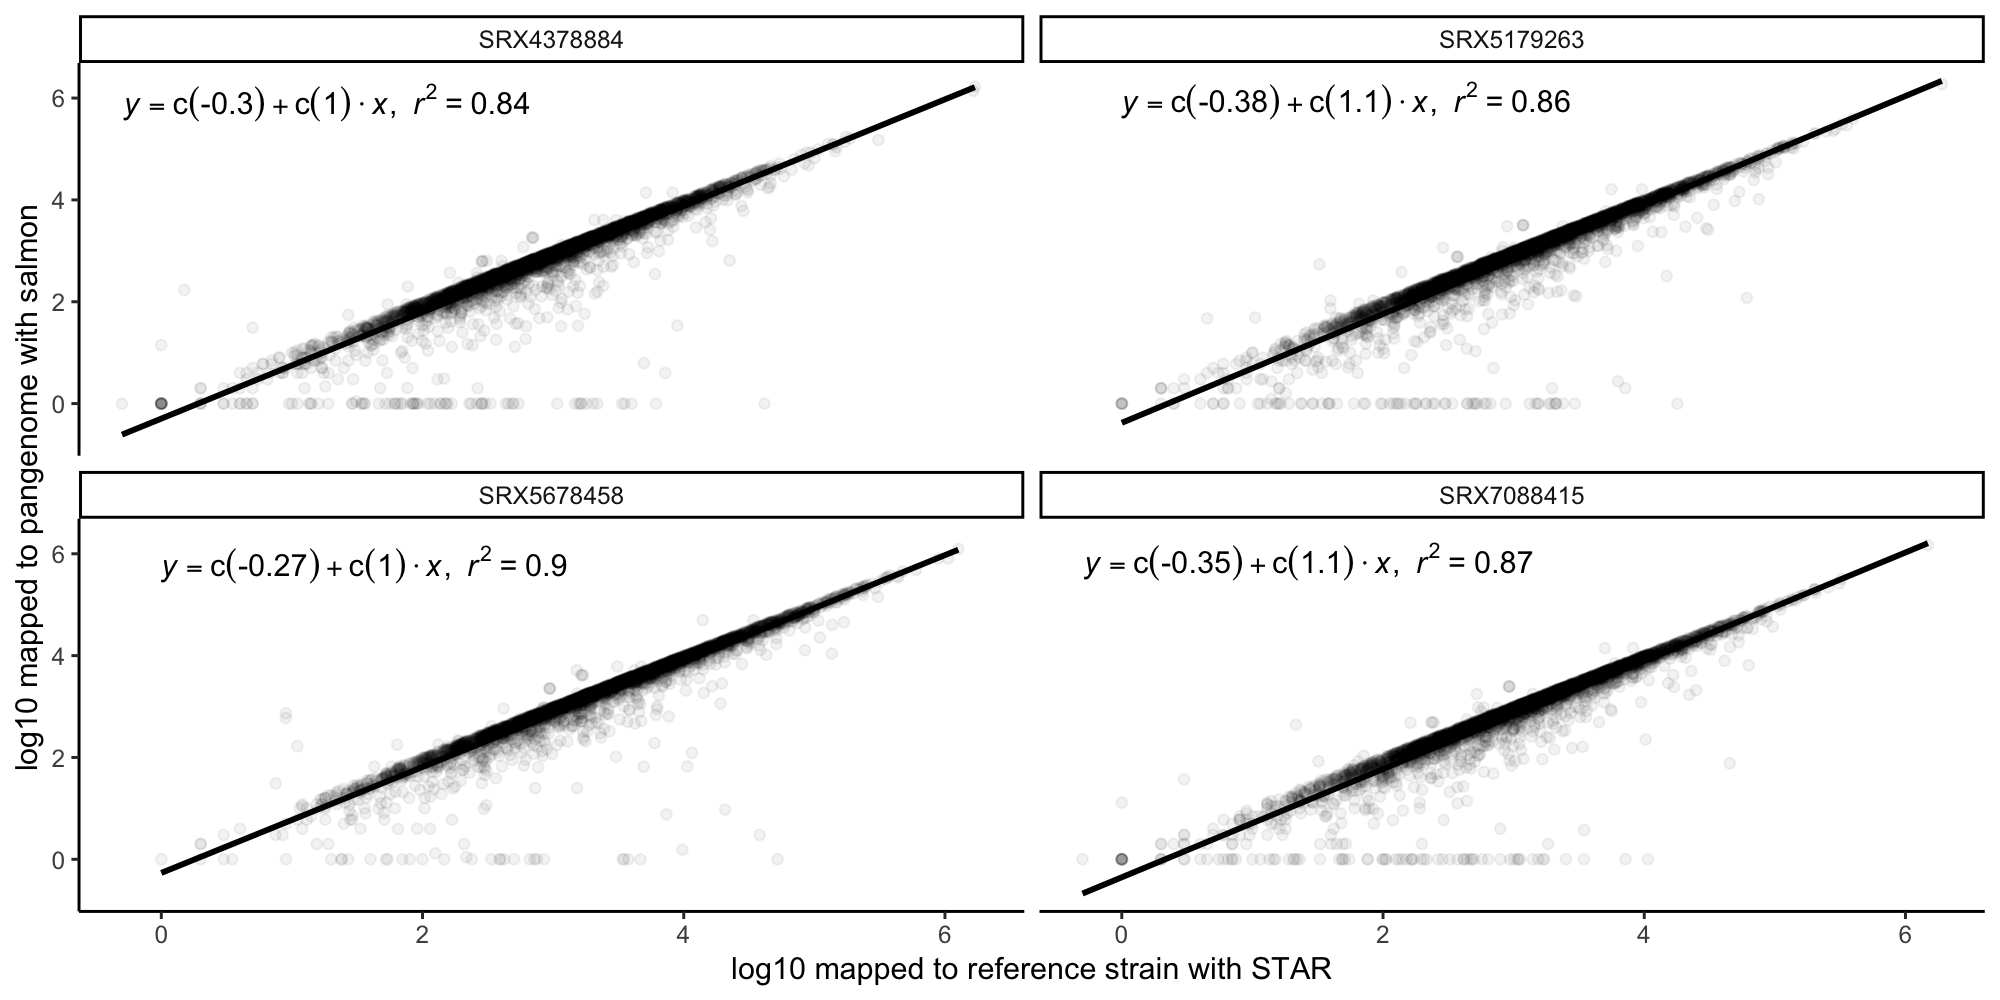

In [8]:
ggplot(counts, aes(x = log10_gs_se_ref_counts, y = log10_salmon_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR",
       y = "log10 mapped to pangenome with salmon") +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  facet_wrap(~sample)

### calculate residuals to determine if outliers are shared across RNA-seq libraries

In [9]:
models <- counts %>% 
  group_by(sample) %>% 
  nest() %>%
  mutate(model = map(data, ~lm(log10_salmon_counts ~ log10_gs_se_ref_counts, data = .)),
         residuals = map2(data, model, add_residuals))

residuals <- models %>% 
  unnest(residuals) %>% 
  select(sample, sequence_name, gs_se_ref_counts, salmon_counts, 
         log10_salmon_counts, log10_gs_se_ref_counts, resid) %>%
  arrange(desc(resid))

In [10]:
residuals

sample,sequence_name,gs_se_ref_counts,salmon_counts,log10_salmon_counts,log10_gs_se_ref_counts,resid
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRX4378884,GCF_000299555.2_11895,1.50,170.000,2.230449,0.1760913,2.3415467
SRX5678458,GCF_000299555.2_05735,9.00,736.000,2.866878,0.9542425,2.1415685
SRX5678458,GCF_000299555.2_11895,9.00,594.000,2.773786,0.9542425,2.0484772
SRX7088415,GCF_000299555.2_11895,21.50,439.000,2.642465,1.3324385,1.5790631
SRX5179263,GCF_000299555.2_11895,32.50,543.000,2.734800,1.5118834,1.4953685
SRX7088415,GCF_000299555.2_15370,1.00,13.000,1.113943,0.0000000,1.4670449
SRX4378884,GCF_000299555.2_06515,0.00,14.000,1.146128,0.0000000,1.4412355
SRX7088415,GCF_000299555.2_06515,3.00,37.000,1.568202,0.4771213,1.4140801
SRX5678458,GCF_000299555.2_06515,11.00,167.000,2.222716,1.0413927,1.4067586


## Paired end data

In [11]:
gs_pe_ref_counts <- Sys.glob("outputs/gs_rnaseq_featurecounts_pe/GCF_000299555.2*counts.txt") %>%
  set_names() %>%
  map_dfr(read_delim, delim = " ", skip = 1, show_col_types = FALSE,
          col_names =  c("sequence_name", "chr", "start", "end", "strand", "length", 
                         "gs_pe_ref_counts"), .id = "sample") %>%
  mutate(sample = gsub("outputs/gs_rnaseq_featurecounts_pe/GCF_000299555.2-", "", sample)) %>%
  mutate(sample = gsub("_counts.txt", "", sample)) %>%
  select(sequence_name, gs_pe_ref_counts, sample)  

In [12]:
head(gs_pe_ref_counts)

sequence_name,gs_pe_ref_counts,sample
<chr>,<dbl>,<chr>
GCF_000299555.2_00015,81.00,SRX4378884
GCF_000299555.2_00020,193.75,SRX4378884
GCF_000299555.2_00025,287.00,SRX4378884
GCF_000299555.2_00030,348.50,SRX4378884
GCF_000299555.2_00035,227.83,SRX4378884
GCF_000299555.2_00040,732.00,SRX4378884


In [13]:
counts2 <- full_join(gs_pe_ref_counts, counts, by = c("sequence_name", "sample")) %>%
  mutate(log10_gs_pe_ref_counts = log10(gs_pe_ref_counts), 
         log10_gs_pe_ref_counts = ifelse(!is.finite(log10_gs_pe_ref_counts), 0, log10_gs_pe_ref_counts))

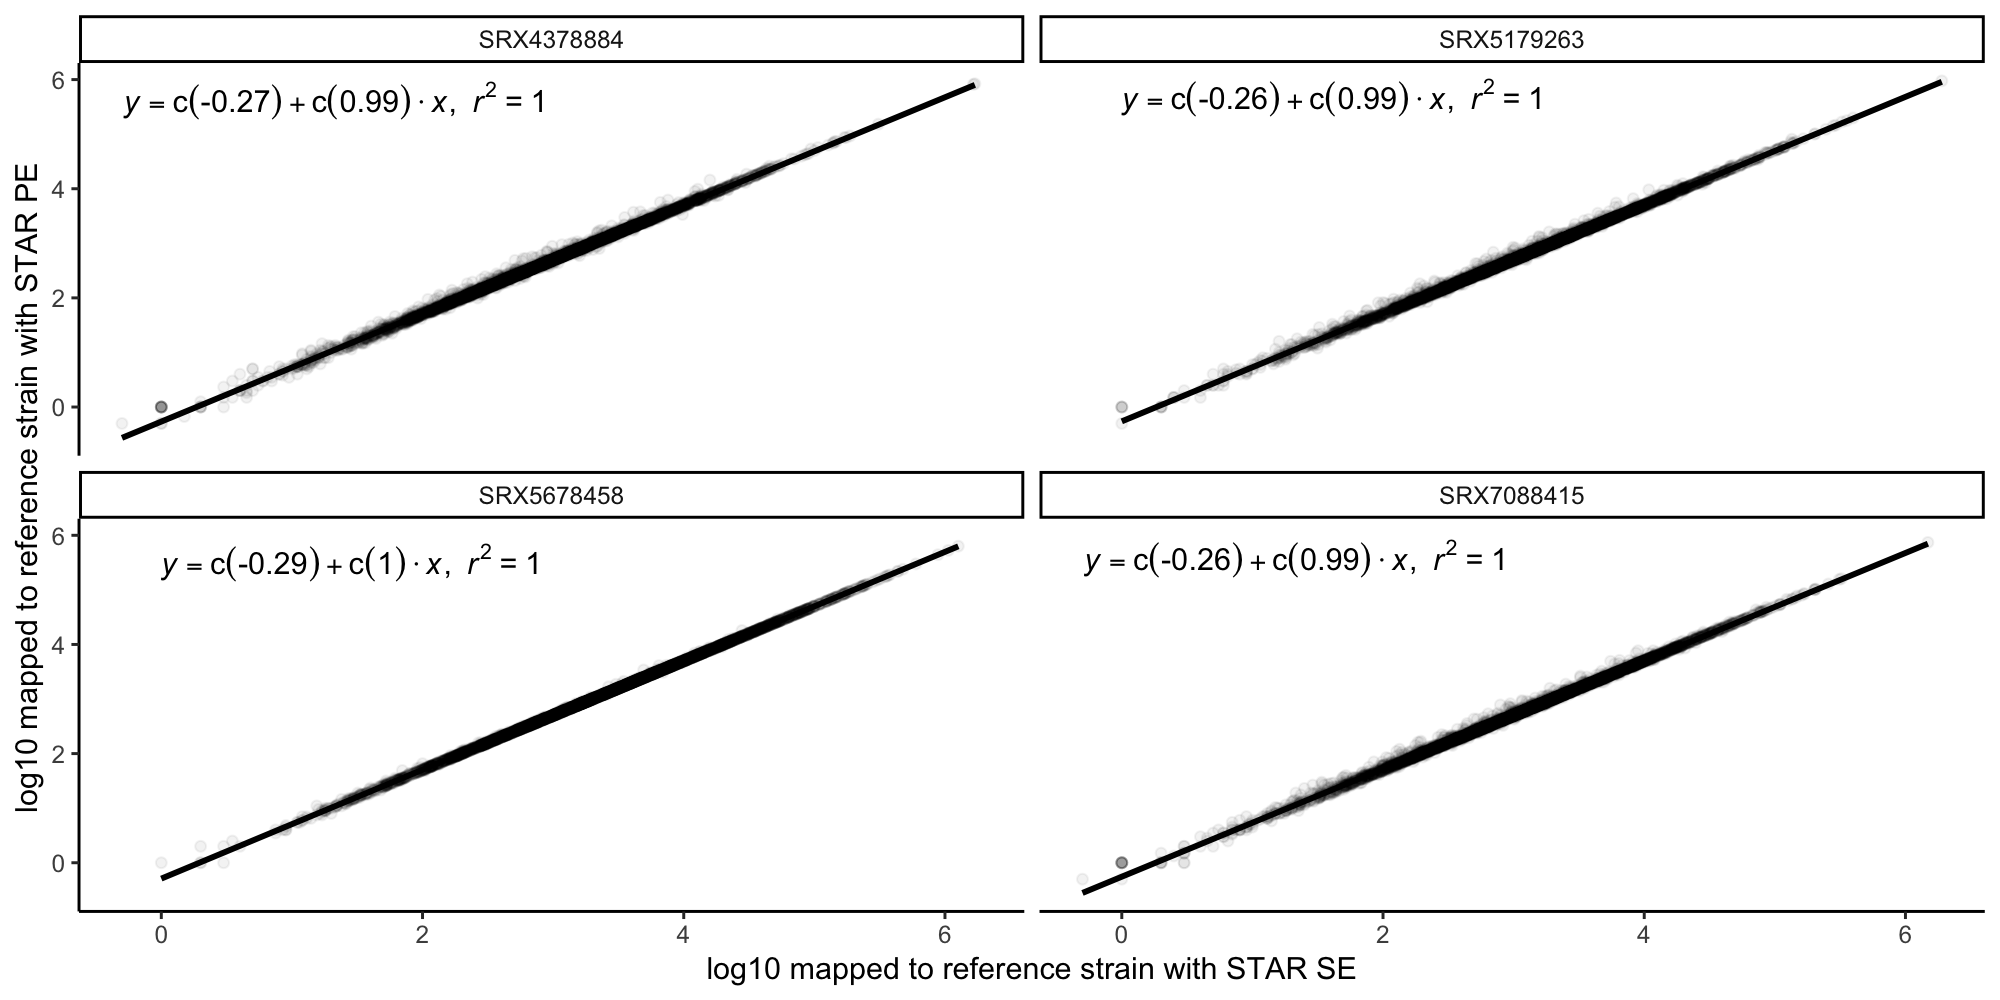

In [14]:
ggplot(counts2, aes(x = log10_gs_se_ref_counts, y = log10_gs_pe_ref_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR SE",
       y = "log10 mapped to reference strain with STAR PE") +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  facet_wrap(~sample)

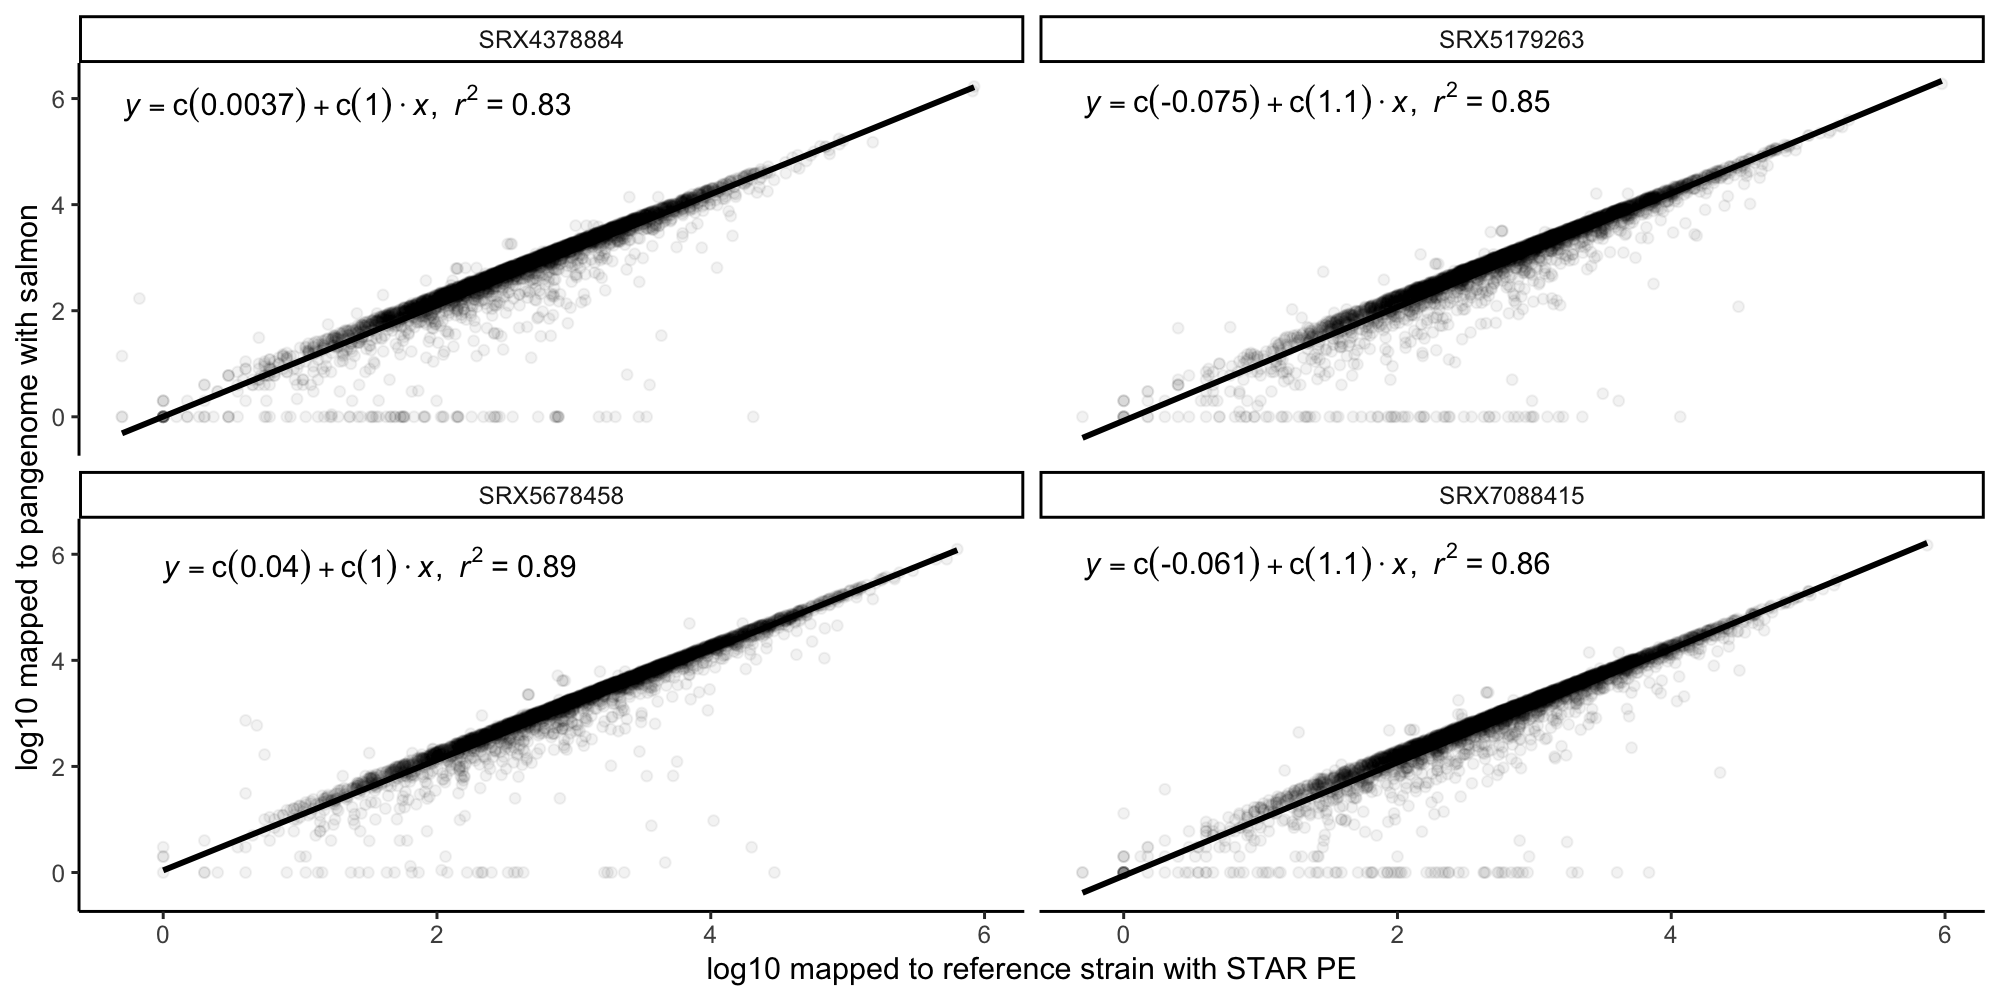

In [15]:
ggplot(counts2, aes(x = log10_gs_pe_ref_counts, y = log10_salmon_counts, label = sequence_name))  +
  geom_point(alpha = .05) +
  theme_classic() +
  labs(x = "log10 mapped to reference strain with STAR PE",
       y = "log10 mapped to pangenome with salmon") +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  facet_wrap(~sample)

## Conclusion

The pangenome pipeline looks like it does a pretty good job of capturing the same information. 

One thing that confused me is the lack of transcripts that fall along the y axis here (or above the diagonal). I would expect that the pangenome would contain some transcripts that were not in the reference represented here, and that these would have ~high read counts, and no read counts for the STAR gs pipeline. Given a lack of such transcripts, I created the notebook `notebooks/20220217_summarize_rnaseq_sourmash_gather_results.ipynb`. This notebook digs into the strain & species-level composition of the libraries investigated above. What I found was although there are multiple strains present in the libraries investigated above, when abundances of k-mers are factored in, there is only one dominant strain. This explains why we don't have transcripts that fall above the diagonal...when considering the majority of reads, only one strain is present, and that strain is captured well by its reference genome.

Basically, I need to re-do this test with a better set of transcriptomes that truly don't have a good reference in our databases.